# Goals

This notebook tests the consistency of our three Shapley value estimators on several different cooperative games. The three estimators are:

- Approximate regression (Section 3.2 of [this paper](https://arxiv.org/abs/2012.01536))
- Unbiased regression (Section 3.3 of [this paper](https://arxiv.org/abs/2012.01536))
- Permutation sampling

The cooperative games we test are:

- Individual predictions (SHAP, see [this paper]())
- Loss for individual predictions (LossSHAP)
- Mean loss with respect to full model output (Shapley Effects, see Appendix A of [this paper](https://arxiv.org/abs/2011.14878))
- Mean dataset loss (SAGE, see [this paper](https://arxiv.org/abs/2004.00668))

# Load data, train model

In [1]:
import sage
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Load data
df = sage.datasets.bank()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_cols = ['Job', 'Marital', 'Education', 'Default', 'Housing',
                    'Loan', 'Contact', 'Month', 'Prev Outcome']
categorical_inds = [feature_names.index(col) for col in categorical_cols]

In [3]:
# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=123)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=123)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [4]:
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.3,
                           depth=10)

model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val),
                  verbose=False)

# SHAP game

In [5]:
import matplotlib.pyplot as plt
from shapreg import removal, games, shapley, shapley_unbiased, shapley_sampling

In [6]:
# Make model callable
model_lam = lambda x: model.predict_proba(x)

# Model extension
marginal_extension = removal.MarginalExtension(train[:128], model_lam)

In [7]:
# Set up game
game = games.PredictionGame(marginal_extension, test[0])

In [8]:
# Run estimators
explanation1 = shapley.ShapleyRegression(game, bar=True, thresh=0.01)
explanation2 = shapley_unbiased.ShapleyRegression(game, bar=True, thresh=0.01)
explanation3 = shapley_sampling.ShapleySampling(game, bar=True, thresh=0.01)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

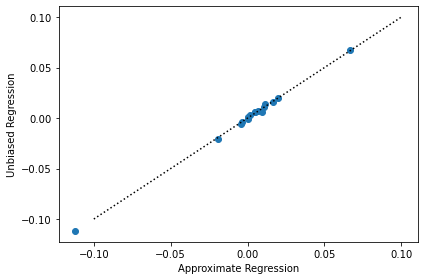

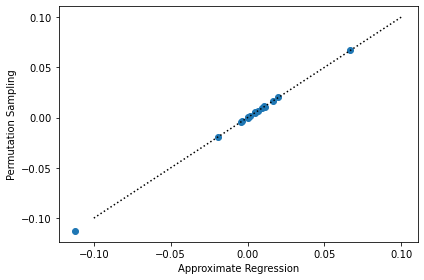

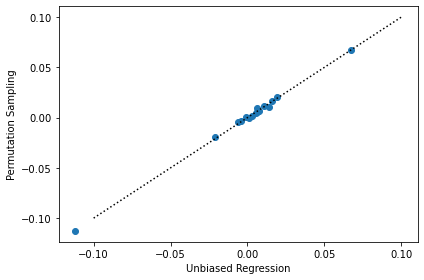

In [9]:
explanations = [explanation1, explanation2, explanation3]
names = ['Approximate Regression', 'Unbiased Regression', 'Permutation Sampling']

for i in range(len(explanations)):
    for j in range(i + 1, len(explanations)):
        plt.figure()

        plt.scatter(explanations[i].values[:, 0], explanations[j].values[:, 0])
        # plt.scatter(explanations[i].values, explanations[j].values)
        plt.plot([-0.1, 0.1], [-0.1, 0.1], linestyle=':', color='black')

        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.tight_layout()
        plt.show()

# LossSHAP game

In [10]:
from shapreg.utils import crossentropyloss

In [11]:
# Set up game
game = games.PredictionLossGame(marginal_extension, test[0], Y_test[0], crossentropyloss)

In [12]:
# Run estimators
explanation1 = shapley.ShapleyRegression(game, bar=True, thresh=0.01)
explanation2 = shapley_unbiased.ShapleyRegression(game, bar=True, thresh=0.01)
explanation3 = shapley_sampling.ShapleySampling(game, bar=True, thresh=0.01)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

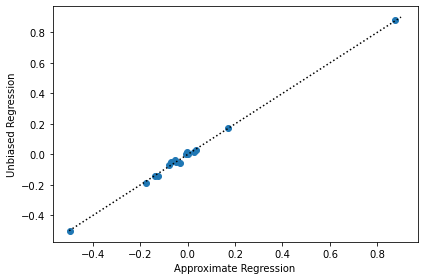

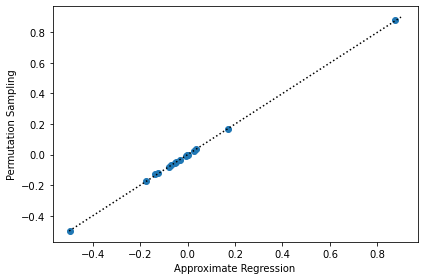

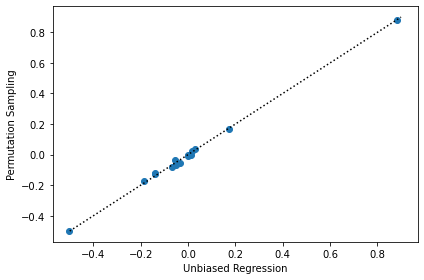

In [13]:
explanations = [explanation1, explanation2, explanation3]
names = ['Approximate Regression', 'Unbiased Regression', 'Permutation Sampling']

for i in range(len(explanations)):
    for j in range(i + 1, len(explanations)):
        plt.figure()

        plt.scatter(explanations[i].values, explanations[j].values)
        plt.plot([-0.5, 0.9], [-0.5, 0.9], linestyle=':', color='black')

        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.tight_layout()
        plt.show()

# Shapley Effects game

In [14]:
from shapreg import stochastic_games

In [15]:
# Set up game
game = stochastic_games.DatasetOutputGame(marginal_extension, test, crossentropyloss)

In [16]:
# Run estimators
explanation1 = shapley.ShapleyRegression(game, bar=True, thresh=0.01)
explanation2 = shapley_unbiased.ShapleyRegression(game, bar=True, thresh=0.01)
explanation3 = shapley_sampling.ShapleySampling(game, bar=True, thresh=0.01)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

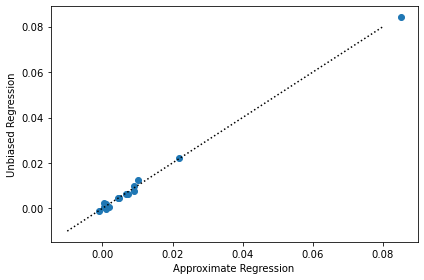

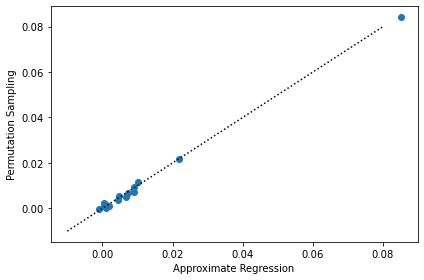

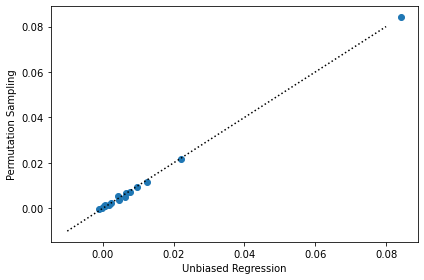

In [17]:
explanations = [explanation1, explanation2, explanation3]
names = ['Approximate Regression', 'Unbiased Regression', 'Permutation Sampling']

for i in range(len(explanations)):
    for j in range(i + 1, len(explanations)):
        plt.figure()

        plt.scatter(explanations[i].values, explanations[j].values)
        plt.plot([-0.01, 0.08], [-0.01, 0.08], linestyle=':', color='black')

        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.tight_layout()
        plt.show()

# SAGE game

In [18]:
# Set up game
game = stochastic_games.DatasetLossGame(marginal_extension, test, Y_test, crossentropyloss)

In [19]:
# Run estimators
explanation1 = shapley.ShapleyRegression(game, bar=True, thresh=0.01)
explanation2 = shapley_unbiased.ShapleyRegression(game, bar=True, thresh=0.01)
explanation3 = shapley_sampling.ShapleySampling(game, bar=True, thresh=0.01)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

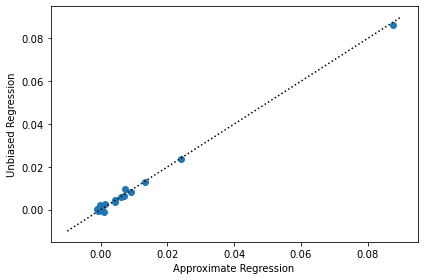

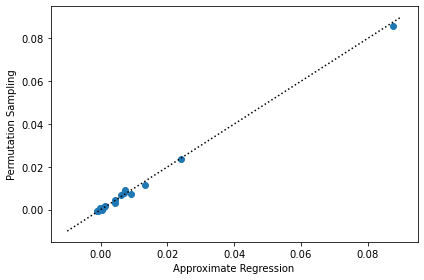

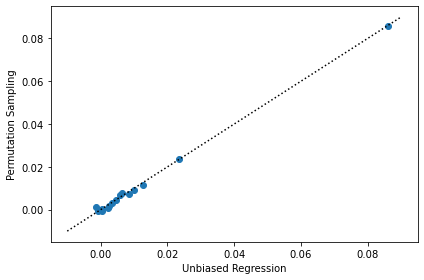

In [20]:
explanations = [explanation1, explanation2, explanation3]
names = ['Approximate Regression', 'Unbiased Regression', 'Permutation Sampling']

for i in range(len(explanations)):
    for j in range(i + 1, len(explanations)):
        plt.figure()

        plt.scatter(explanations[i].values, explanations[j].values)
        plt.plot([-0.01, 0.09], [-0.01, 0.09], linestyle=':', color='black')

        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.tight_layout()
        plt.show()